In [80]:
%matplotlib inline
import tensorflow as tf
import numpy as np
# from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
from matplotlib import pyplot as plt
import math
import othello
from input_data import input_data
from PIL import Image, ImageDraw, ImageFont
import re

tf.__version__
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 32         # There are 36 of these filters.
fc_size = 128             # Number of neurons in fully-connected layer.


# data.test.cls = np.argmax(data.test.labels, axis=1)
board_size = 8
board_size_flat = board_size * board_size
board_shape = (board_size, board_size)
num_channels = 1
num_classes = 2

train = input_data("data/NN_saved_games.dat")


In [2]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))


def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [78]:
def image_from_board(board):
    printable_board = othello.print_board(TF2othello(board))
    printable_board = " " + printable_board.replace(" ", "")
    printable_board = re.sub("\d", "", printable_board)
    #im = Image.new('RGB', (105, 130), "white")
    im = Image.new('RGBA', (130, 210), (255, 255, 255))

    d = ImageDraw.Draw(im)
    font = ImageFont.truetype("fonts/consola.ttf", 25)
    d.text((2, 0), printable_board, (0,0,0), font=font)
    plt.axis('off')
    # return im.resize((130, 130), Image.ANTIALIAS)
    return im

In [4]:
def plot_boards(boards, winners, cls_pred=None):
    assert len(boards) == len(winners) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    winners = ["O" if w == 1 else "X" for w in winners]
    if cls_pred is not None:
        cls_pred = ["O" if w == 1 else "X" for w in cls_pred]
    
    for i, ax in enumerate(axes.flat):
        # Create image
        im = image_from_board(boards[i])
        # Plot image.
        ax.imshow(im)

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "Winner: {0}".format(winners[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(winners[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [5]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.
    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)
    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases
    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.
    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [6]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features


def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [15]:
x = tf.placeholder(tf.float32, shape=[None, board_size_flat], name='x')
x_image = tf.reshape(x, [-1, board_size, board_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)
layer_conv1, weights_conv1 =     new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=False)
layer_conv1
layer_conv2, weights_conv2 =     new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv2
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat
num_features
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc1
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 64
total_iterations = 0

In [8]:
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    # Start-time used for printing time-usage below.
    start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = train.next_batch(train_batch_size)
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            # Print it.
            print(msg.format(i + 1, acc))
    # Update the total number of iterations performed.
    total_iterations += num_iterations
    # Ending time.
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


test_batch_size = 256


# def predict_image(image):
#     feed_dict = {x: [image],
#             y_true: data.test.labels[0:0]}
#     cls_pred = session.run(y_pred_cls, feed_dict = feed_dict)
#     return cls_pred[0]

In [9]:
def plot_conv_layer(layer, board):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.
    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [board]}
    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]
    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)
    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]
            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [10]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [16]:
optimize(num_iterations=2000)

Optimization Iteration:      1, Training Accuracy:  37.5%
Optimization Iteration:    101, Training Accuracy:  79.7%
Optimization Iteration:    201, Training Accuracy:  89.1%
Optimization Iteration:    301, Training Accuracy:  73.4%
Optimization Iteration:    401, Training Accuracy:  76.6%
Optimization Iteration:    501, Training Accuracy:  81.2%
Optimization Iteration:    601, Training Accuracy:  84.4%
Optimization Iteration:    701, Training Accuracy:  82.8%
Optimization Iteration:    801, Training Accuracy:  85.9%
Optimization Iteration:    901, Training Accuracy:  78.1%
Optimization Iteration:   1001, Training Accuracy:  90.6%
Optimization Iteration:   1101, Training Accuracy:  95.3%
Optimization Iteration:   1201, Training Accuracy:  89.1%
Optimization Iteration:   1301, Training Accuracy:  87.5%
Optimization Iteration:   1401, Training Accuracy:  81.2%
Optimization Iteration:   1501, Training Accuracy:  79.7%
Optimization Iteration:   1601, Training Accuracy:  78.1%
Optimization I

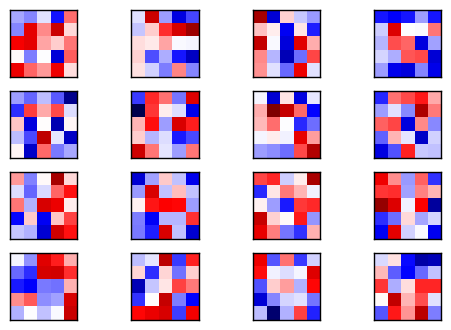

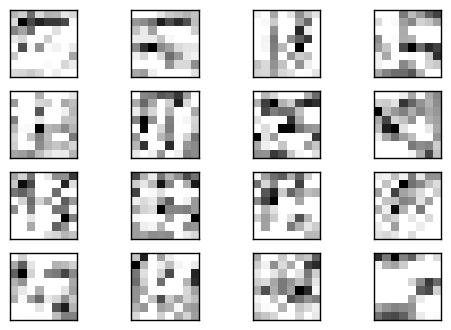

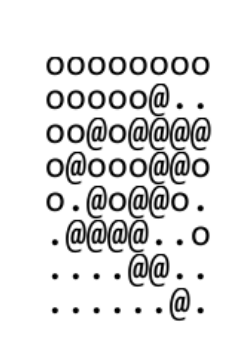

In [81]:
plot_conv_weights(weights=weights_conv1)
board, _ = train.next_batch(1)
board = np.reshape(board, 64)
test_boards, test_winners = train.next_batch(9)
#plot_boards(test_boards, test_winners)
plot_conv_layer(layer_conv1, board)
plt.imshow(image_from_board(board))

In [82]:
def TF_eval(sess, y):
    def TF_weighted(player, board):
        game_x = othello2TF(board)
        y_pred = sess.run(tf.nn.softmax(y), feed_dict={x: game_x})[0]
        player = 1 if player == "o" else 0
        return y_pred[player]
    return TF_weighted


def othello2TF(board):
    x = np.array(board)
    x = np.reshape(np.reshape(x, (10, 10))[1:9,1:9], 64)
    x = np.array([1 if sq == "o" else -1 if sq == "@" else 0 for sq in x], np.float32)
    x = np.reshape(x, (-1, 64))
    return x


def TF2othello(x):
    board = np.zeros((10, 10))
    board[:] = 15
    x = np.reshape(x, (8, 8))
    board[1:9, 1:9] = x
    board = list(np.reshape(board, 100))
    board = ["o" if sq == 1 else "@" if sq == -1 else "?" if sq == 15 else  "." for sq in board]
    return board

In [87]:
def play_testgame():
    conv_player = othello.alphabeta_searcher(2, TF_eval(session, y_pred))
    opponent = othello.alphabeta_searcher(2, othello.weighted_score(othello.SQUARE_WEIGHTS))
    game, winner = othello.play_game(opponent, conv_player)
    game_xs = []
    for board in game:
        game_xs.append(othello2TF(board))
    game_xs = np.reshape(game_xs, (-1, 64))
    y = session.run(tf.nn.softmax(y_pred), feed_dict={x: game_xs})
    return zip(game_xs, y)

In [ ]:
print(list(data))

TF-graph predicts 54.77% chance of win
TF-graph predicts 55.18% chance of win
TF-graph predicts 56.40% chance of win
TF-graph predicts 54.88% chance of win
TF-graph predicts 57.78% chance of win
TF-graph predicts 62.00% chance of win
TF-graph predicts 59.78% chance of win
TF-graph predicts 61.82% chance of win
TF-graph predicts 56.38% chance of win
TF-graph predicts 63.46% chance of win
TF-graph predicts 50.12% chance of win
TF-graph predicts 46.75% chance of win
TF-graph predicts 47.45% chance of win
TF-graph predicts 49.75% chance of win
TF-graph predicts 57.05% chance of win
TF-graph predicts 65.34% chance of win
TF-graph predicts 61.81% chance of win
TF-graph predicts 65.12% chance of win
TF-graph predicts 52.99% chance of win
TF-graph predicts 47.52% chance of win
TF-graph predicts 43.58% chance of win
TF-graph predicts 41.73% chance of win
TF-graph predicts 38.63% chance of win
TF-graph predicts 37.79% chance of win
TF-graph predicts 39.75% chance of win
TF-graph predicts 43.23% 

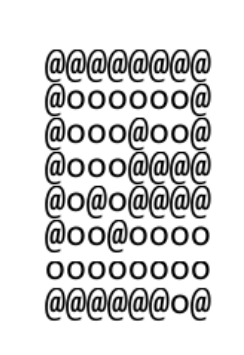

In [111]:
data = play_testgame()

for board, prediction in list(data):
    plt.imshow(image_from_board(board))
    print("TF-graph predicts {:.2f}% chance of win".format(100 - prediction[0]*100))
    plt.show()t
    #input()
    

In [92]:
# session.close()

KeyboardInterrupt: 